NEKG part

In [1]:
import ampligraph
import pandas as pd
import numpy as np
from ampligraph.latent_features import TransE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# Knowledge Graph Construction.
def graph_construction(start, stop, step):
    kg = pd.DataFrame()
    kg['h'] = [i for i in np.arange(start, stop, step)]
    kg['r'] = ['isLessThan'] * int((stop-start) / step)
    kg['t'] = [i for i in np.arange(step, stop+1, step)]
    kg["h"] = kg.h.values.astype(str)
    kg["t"] = kg.t.values.astype(str)
    return kg

In [3]:
start = 0
stop = 1000
step = 5
kg_df = graph_construction(start, stop, step)
kg_df.head()

,h,r,t
0,0,isLessThan,5
1,5,isLessThan,10
2,10,isLessThan,15
3,15,isLessThan,20
4,20,isLessThan,25


In [4]:
##kg embedding
kg_array = kg_df.to_numpy().astype(str)
model = TransE(epochs=200, k=100, verbose=True)
model.fit(kg_array)

2022-11-09 02:58:42.735878: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-11-09 02:58:42.763892: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2592010000 Hz
2022-11-09 02:58:42.767285: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561e49b51a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-09 02:58:42.767362: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-11-09 02:58:42.774934: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-09 02:58:43.711706: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:969] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-09 02:58:43.711

In [5]:
# Dimensionality reduction using t-SNE---visualize the embedding
embeddings = model.get_embeddings(entities=[str(j) for j in np.arange(start, stop+1, step)], embedding_type='entity')
embeddings = np.asarray(embeddings, dtype='float64')
embeddings_tSNE = TSNE(n_components=2).fit_transform(embeddings)
embeddings_tSNE = pd.DataFrame(embeddings_tSNE, columns=['tSNE_1', 'tSNE_2'])
embeddings_tSNE['magnitude'] = [i for i in range(start, stop+1, step)]
embeddings_tSNE.head()

/home/egbert_jing/anaconda3/envs/4222G18/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/egbert_jing/anaconda3/envs/4222G18/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


,tSNE_1,tSNE_2,magnitude
0,-8.707905,-11.385519,0
1,-8.686136,-11.306353,5
2,-8.933662,-11.274024,10
3,-8.603120,-11.075414,15
4,-9.107282,-11.081219,20


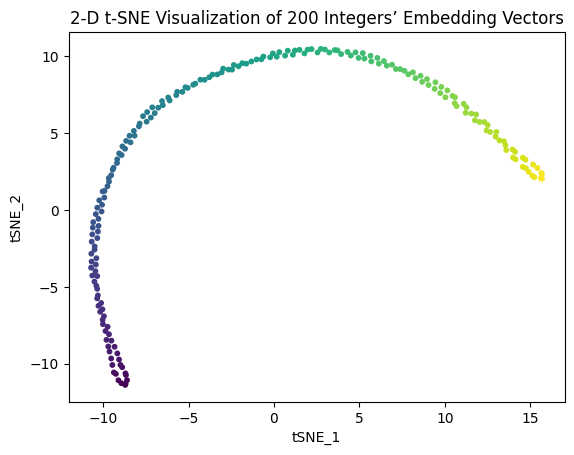

In [6]:
# Visualize the embedding vectors in 2-D space.
plt.scatter(embeddings_tSNE.tSNE_1, embeddings_tSNE.tSNE_2, c=embeddings_tSNE.magnitude, s=10)
plt.title('2-D t-SNE Visualization of 200 Integers’ Embedding Vectors')
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.show()

In [7]:
# Measure the similarity between numbers--处理oov number
def cal_sim(x1, x2, x3):
    return (x2-x1)/(x3-x1)

In [8]:
# Obtain embedding vectors for OOVs.
OOVs = range(0, 1000)
OOV_embeddings = []
for i in OOVs:
    for j in np.arange(start, stop+1, step):
        if i < j:
            upper = j
            lower = j-step
            e1 = model.get_embeddings(str(lower), embedding_type='entity')
            e2 = model.get_embeddings(str(upper), embedding_type='entity')
            s2 = cal_sim(lower, i, upper)
            s1 = 1-s2            
            OOV_embeddings.append(e1 * s1 + e2 * s2)
            break

In [9]:
# Dimensionality reduction using t-SNE.
OOV_embeddings = np.asarray(OOV_embeddings, dtype='float64')
OOV_embeddings_tSNE = TSNE(n_components=2).fit_transform(OOV_embeddings)
OOV_embeddings_tSNE = pd.DataFrame(OOV_embeddings_tSNE, columns=['tSNE_1', 'tSNE_2'])
OOV_embeddings_tSNE['magnitude'] = OOVs
OOV_embeddings_tSNE.head()

/home/egbert_jing/anaconda3/envs/4222G18/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/egbert_jing/anaconda3/envs/4222G18/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


,tSNE_1,tSNE_2,magnitude
0,0.104079,-47.782223,0
1,-0.021374,-47.693958,1
2,-0.246736,-47.627911,2
3,-0.501886,-47.527813,3
4,-0.732385,-47.407131,4


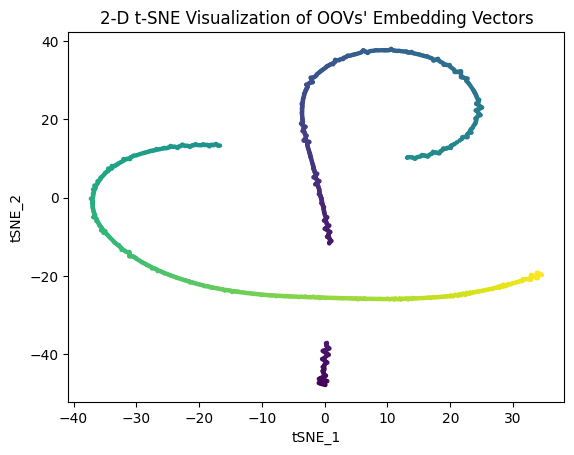

In [10]:
# Visualize the embedding vectors of OOVs in 2-D space.
plt.scatter(OOV_embeddings_tSNE.tSNE_1, OOV_embeddings_tSNE.tSNE_2, c=OOV_embeddings_tSNE.magnitude, s=5)
plt.title('2-D t-SNE Visualization of OOVs\' Embedding Vectors')
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.show()

In [11]:
OOV_embeddings.shape#0到999的embedding

(1000, 100)

In [12]:
np.save("nekg 1-999 100d.npy",OOV_embeddings)